# Requirements and Imports

In [1]:
%pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
import seaborn as sns

from keras import backend as K
from sklearn.metrics import confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from dataset import RichHDF5Dataset, HDF5Dataset, split_strategy, reduce_sets
from network import Net
from losses import make_cost_matrix, qwk_loss
from metrics import np_quadratic_weighted_kappa
from utilities import print_split_diagnostic_info, plot_split_graphs

In [3]:
# Set the device to GPU 
gpu = len(tf.config.list_physical_devices('GPU'))>0
if gpu: 
    tf.config.set_visible_devices([tf.config.list_physical_devices('GPU')[0],tf.config.list_physical_devices('CPU')[0]])
    tf.config.experimental.set_memory_growth(tf.config.list_physical_devices('GPU')[0], True)
    print("GPU acceleration available.")

GPU acceleration available.


# Settings

In [4]:
# ============== settings ==============
dataset_h5 = "/Users/edoardoconti/Tesi/iclus/dataset.h5"
pkl_framesmap = "/Users/edoardoconti/Tesi/iclus/hdf5_frame_index_map.pkl"
pkl_centersdict = "/Users/edoardoconti/Tesi/iclus/hospitals-patients-dict.pkl"
batch_size = 8
epochs = 20
use_less_data = True
seed = 42

# Dataset

277 videos (58924 frames) loaded from cached data.
dataset split: train=36218(61%), val=11035(19%), test=11671(20%)


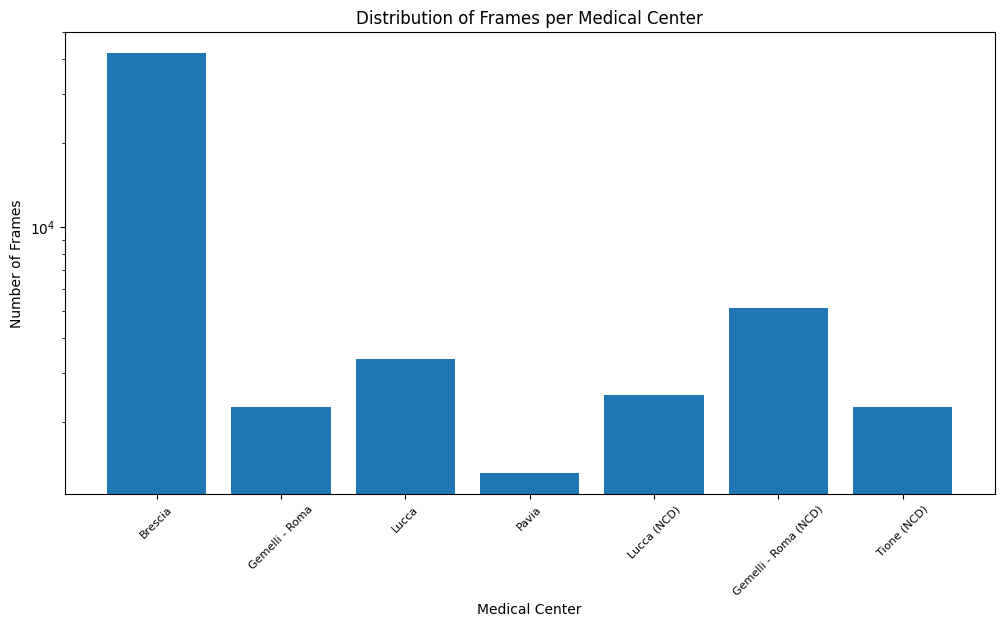

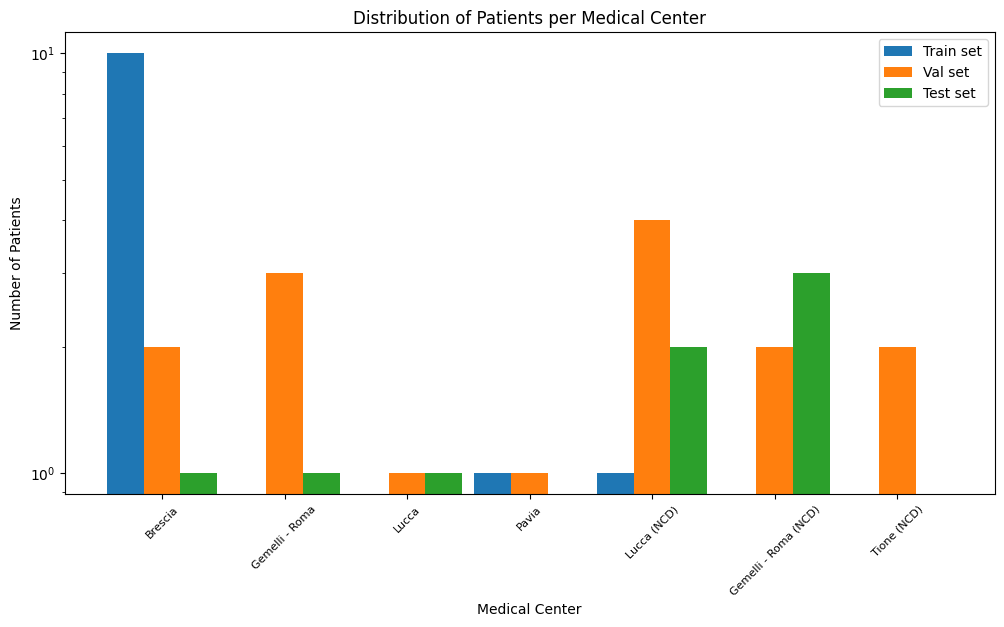

dataset reduction: 15% (train=5432, val=1655, test=1750)


In [5]:
# ============== dataset ===============
# Create the custom rich dataset useful for the splitting step
dataset = RichHDF5Dataset(dataset_h5, pkl_framesmap)

# Splitting the dataset into train, (validation) and test sets
split_ratios = [0.6, 0.2, 0.2]
train_subset, val_subset, test_subset, ds_info = split_strategy(dataset, ratios=split_ratios, pkl_file=pkl_centersdict, rseed=seed)

# optional
# print_split_diagnostic_info(ds_info)
plot_split_graphs(train_subset, val_subset, test_subset, ds_info)

# use a smaller part of the dataset 
if use_less_data:
     train_subset, val_subset, test_subset = reduce_sets(train_subset, val_subset, test_subset, 0.15)

# Create the train, (val) and test sets to feed the neural network
train_dataset = HDF5Dataset(dataset, train_subset, batch_size, augmentation=True)
val_dataset = HDF5Dataset(dataset, val_subset, batch_size)
test_dataset = HDF5Dataset(dataset, test_subset, batch_size)

### Class Weight

In [6]:
# Retrieves the dataset's labels
ds_labels = ds_info['labels']

# Extract the train and test set labels
y_train_labels = np.array(ds_labels)[train_subset]
y_test_labels = np.array(ds_labels)[test_subset]

# Calculate class balance using 'compute_class_weight'
class_weights = compute_class_weight('balanced', classes=np.unique(y_train_labels), y=y_train_labels)

# Create a dictionary that maps classes to their weights
class_weight_dict = dict(enumerate(class_weights))

print("Class Weights: ", class_weight_dict)

Class Weights:  {0: 1.1131147540983606, 1: 0.8175797712221553, 2: 0.7065556711758585, 3: 2.1589825119236883}


# Neural Network Model

In [ ]:
# NNet object
ds_img_size = 224
ds_num_channels = 3
ds_num_classes = 4
nn_activation = 'relu'
nn_final_activation = 'poml'
nn_dropout = 0
clm_use_tau = True
net_type = 'resnet18' # 'conv128', 'resnet18'

net_object = Net(ds_img_size, nn_activation, nn_final_activation, ds_num_channels,
                 ds_num_classes, nn_dropout, clm_use_tau)

model = net_object.build(net_type)

In [ ]:
# Loss
cost_matrix = K.constant(make_cost_matrix(ds_num_classes), dtype=K.floatx())
loss = qwk_loss(cost_matrix)

# Metrics
metrics = ['accuracy']

# Iper-parameters
lr = 1e-2
lr_decay = 1e-6

# Compile the keras model
model.compile(
    #optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=lr),
    optimizer = tf.keras.optimizers.legacy.SGD(learning_rate=lr, decay=lr_decay, momentum=0.9, nesterov=True),
    loss=loss, 
    metrics=metrics
)

# Print model summary
model.summary()

# Training Neural Network

In [ ]:
history = model.fit(train_dataset, 
                    shuffle=True,
                    epochs=epochs,
                    class_weight=class_weight_dict,
                    validation_data=val_dataset
                    )

In [ ]:
# Plot Training loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('QWK loss')
plt.title('ResNet18-CLM for Ordinal Classification')
plt.grid()
plt.show

In [ ]:
# Plot Training accuracy
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('ResNet18-CLM for Ordinal Classification')
plt.grid()
plt.show

# Evaluate

In [ ]:
model.evaluate(test_dataset)

In [ ]:
y_test_pred = model.predict(test_dataset)
y_test_pred = np.argmax(y_test_pred, axis=1) # extract classes from probabilities

In [ ]:
# Test Set Confusion Matrix
cf_matrix_test = confusion_matrix(y_test_labels, y_test_pred, normalize='true', labels=list(range(ds_num_classes)))

ax = sns.heatmap(cf_matrix_test, linewidths=1, annot=True, fmt='.2f')
ax.set_ylabel(f'Actual')
ax.set_xlabel(f'Predicted')
ax.set_title(f'Test Set Confusion Matrix')
plt.show()

In [ ]:
qwk_test = np_quadratic_weighted_kappa(y_test_labels, y_test_pred, 0, ds_num_classes - 1)

print('QWK Test Set: {:.4f}'.format(qwk_test))